In [2]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [3]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [4]:
library("clustree")

Loading required package: ggraph



In [5]:

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [6]:
normal.data <- Read10X(data.dir = "./filtered_gene_pAL_PC_2")
normal <- CreateSeuratObject(counts = normal.data, project = "pALPC2", min.cells = 3, min.features = 100)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [7]:
normal

An object of class Seurat 
16253 features across 2747 samples within 1 assay 
Active assay: RNA (16253 features, 0 variable features)

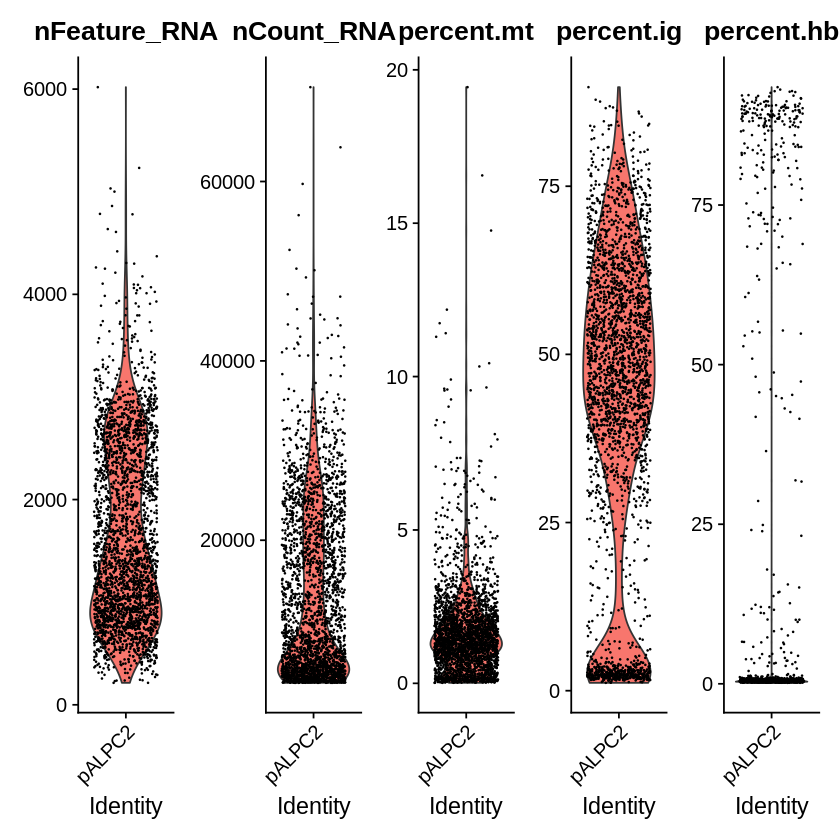

In [8]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

In [9]:
summary(normal@meta.data)

  orig.ident     nCount_RNA     nFeature_RNA    percent.mt      
 pALPC2:2747   Min.   : 4101   Min.   : 214   Min.   : 0.01627  
               1st Qu.: 5673   1st Qu.: 923   1st Qu.: 0.81020  
               Median : 9949   Median :1445   Median : 1.40065  
               Mean   :13610   Mean   :1664   Mean   : 1.65680  
               3rd Qu.:20412   3rd Qu.:2406   3rd Qu.: 2.08076  
               Max.   :70522   Max.   :6019   Max.   :19.43450  
   percent.ig       percent.hb     
 Min.   : 1.169   Min.   : 0.1520  
 1st Qu.:31.006   1st Qu.: 0.3579  
 Median :46.892   Median : 0.4372  
 Mean   :42.340   Mean   : 7.4837  
 3rd Qu.:59.134   3rd Qu.: 0.5776  
 Max.   :89.726   Max.   :93.4687  

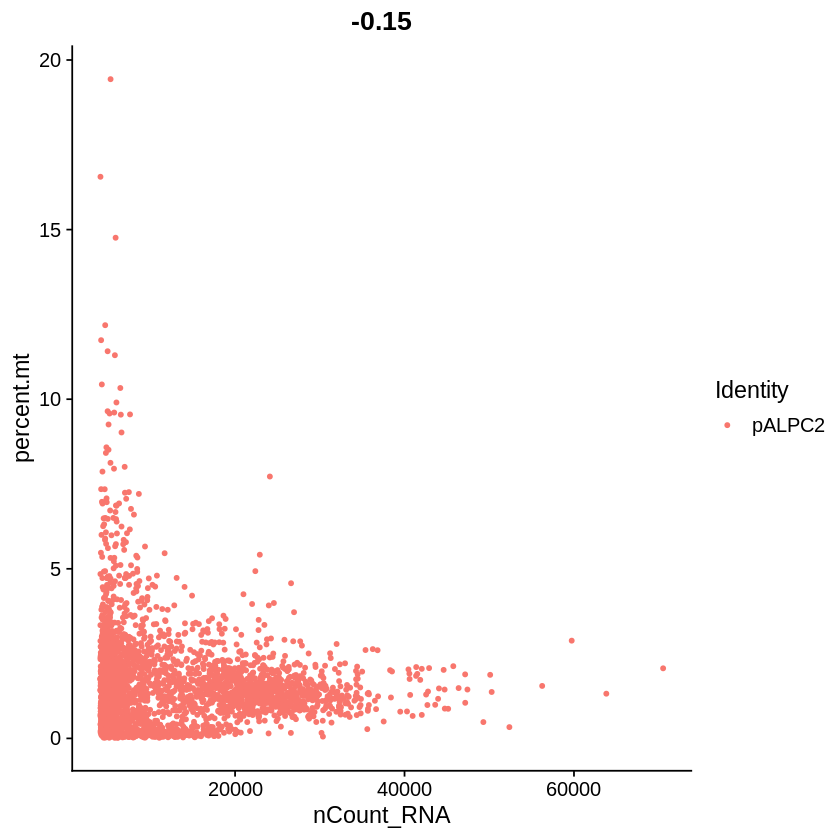

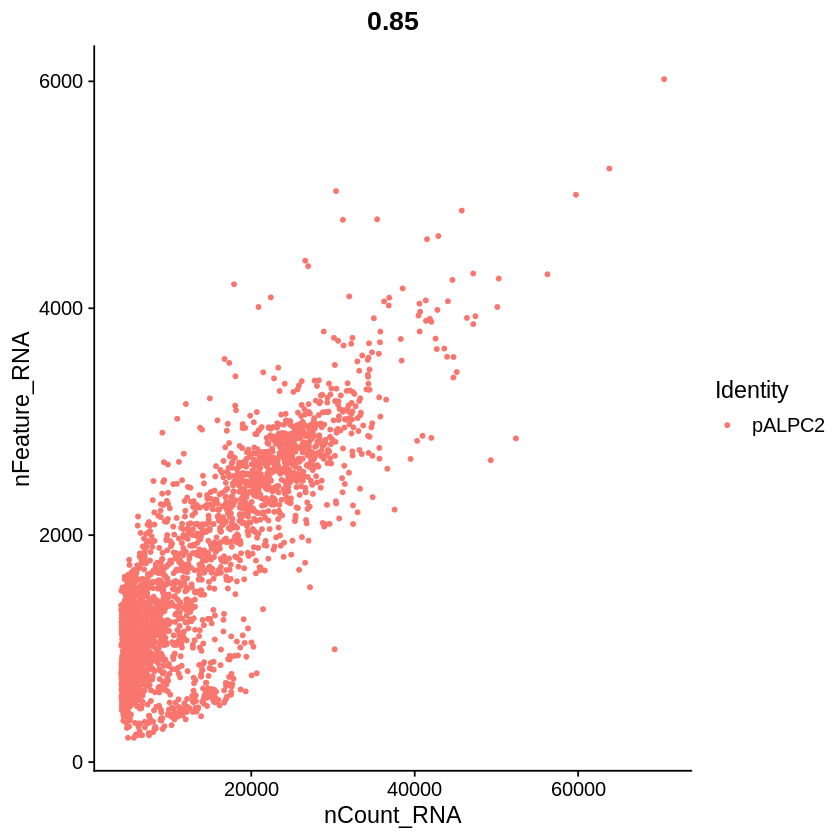

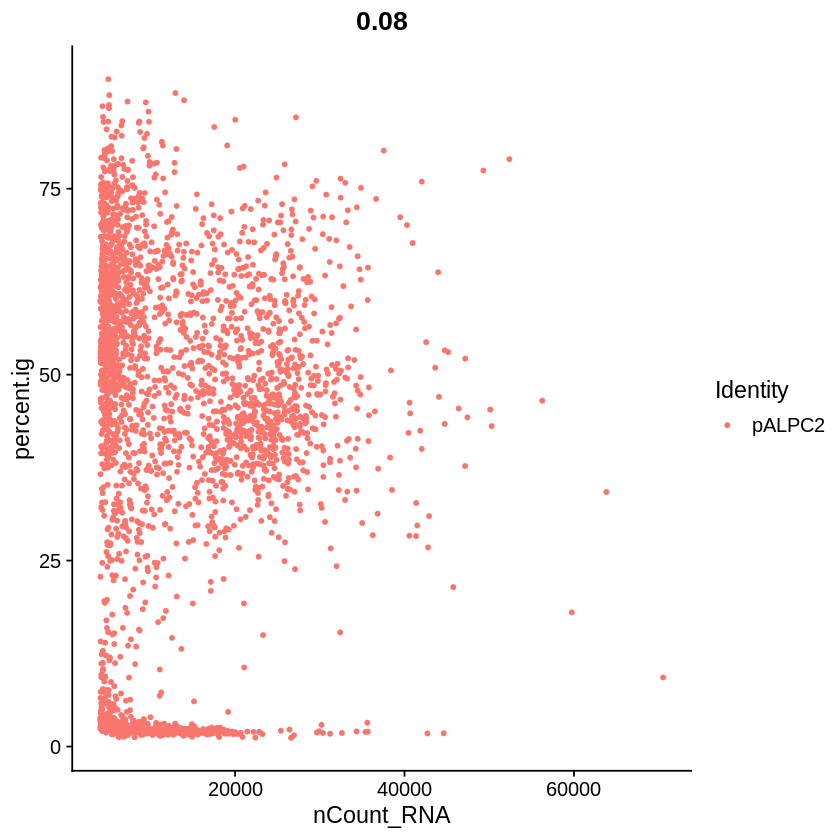

In [10]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [11]:
normal <- subset(normal, subset = nFeature_RNA > 100 & nFeature_RNA < 4000 & percent.mt < 5 & percent.hb < 1)
normal

An object of class Seurat 
16253 features across 2334 samples within 1 assay 
Active assay: RNA (16253 features, 0 variable features)

In [12]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 44 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 44 rows containing missing values (geom_point).”


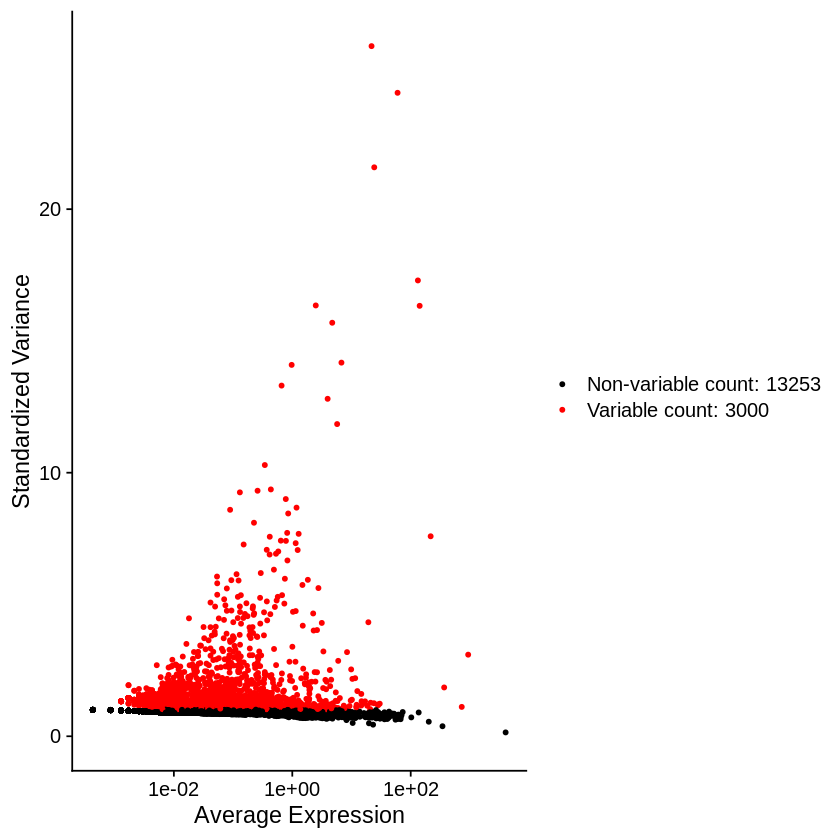

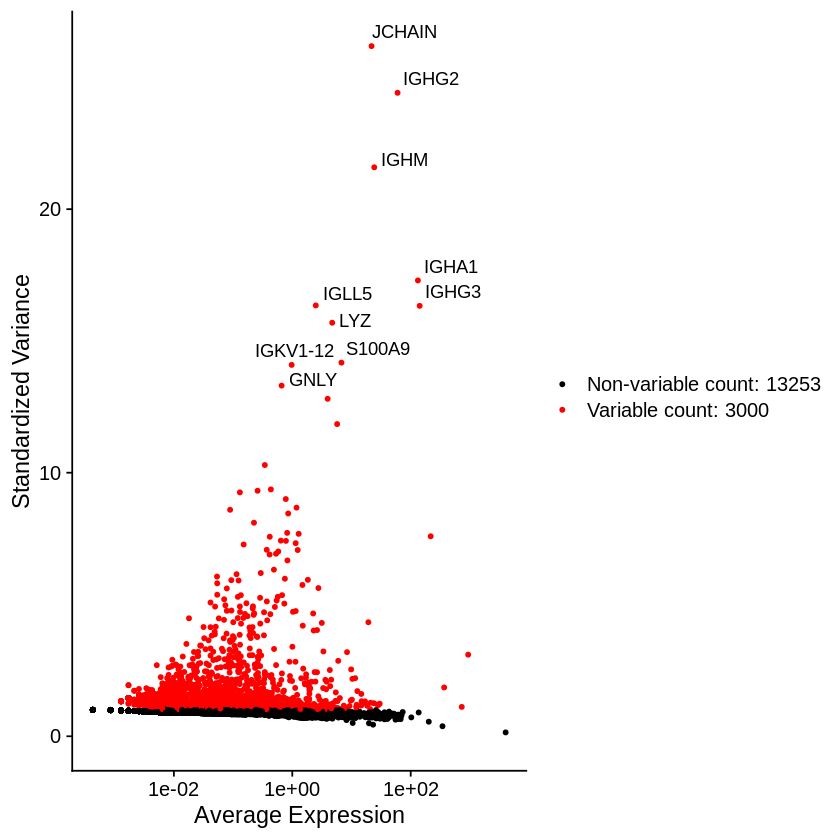

In [13]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [14]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [15]:
length(VariableFeatures(object = normal))

[1] 3000

In [16]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  MZB1, FKBP11, SEC11C, ITM2C, HSP90B1, XBP1, FKBP2, IGLC3, DNAJB9, GAS6 
	   IGHG4, HERPUD1, DERL3, LMAN2, KRTCAP2, QPCT, HLA-DOB, IGHE, TNFRSF17, CUTA 
	   SDF2L1, UBE2J1, TXNDC11, JUN, KDELR1, CD63, TUBB2B, CRELD2, PTP4A3, TNFRSF13B 
Negative:  TMSB4X, S100A4, ARHGDIB, COTL1, LAPTM5, TMSB10, CORO1A, LCP1, PTPRC, TYROBP 
	   S100A10, FCER1G, HLA-DRA, LST1, ACTB, ITGB2, SH3BGRL3, CSTA, FCN1, PFN1 
	   CFL1, CD52, HLA-DPB1, MNDA, S100A6, LSP1, SERPINA1, LYZ, VCAN, SAMHD1 
PC_ 2 
Positive:  IL32, CD3E, TRAC, CD3D, TRBC2, LCK, CD2, CD7, GZMM, CD3G 
	   EVL, ACAP1, CCL5, GZMA, LBH, IL7R, CD247, LAT, LTB, TRBC1 
	   PRKCH, CD8A, CST7, LINC00861, CLEC2D, NKG7, SH2D1A, CD8B, PRF1, KLRG1 
Negative:  CSTA, FCN1, SERPINA1, VCAN, CD14, MNDA, CLEC12A, FCER1G, CFD, LYZ 
	   FGL2, CTSS, MPEG1, LGALS2, NCF2, SPI1, LST1, KCTD12, FOS, TYMP 
	   LGALS3, S100A12, MS4A6A, CLEC7A, CD302, CYBA, CPVL, RNF130, IGSF6, DUSP6 
PC_ 3 
Positive:  KIAA0101, STMN1, HIST1H4C, NUSAP1, CENPF, BIRC5, MK

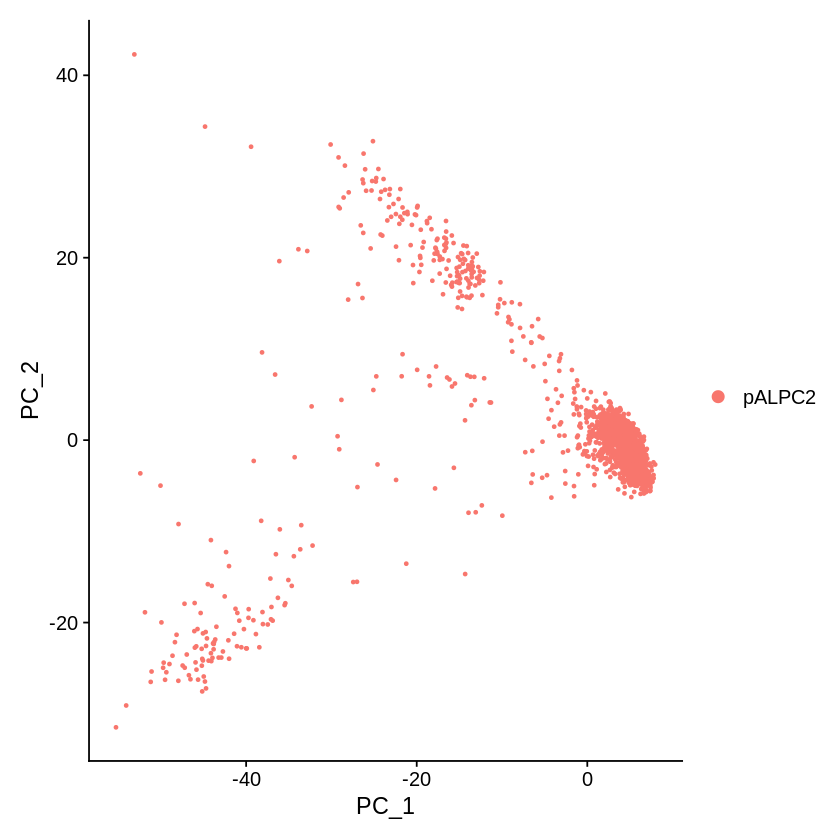

In [17]:
DimPlot(normal, reduction = "pca")

In [18]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42053 rows containing missing values (geom_point).”


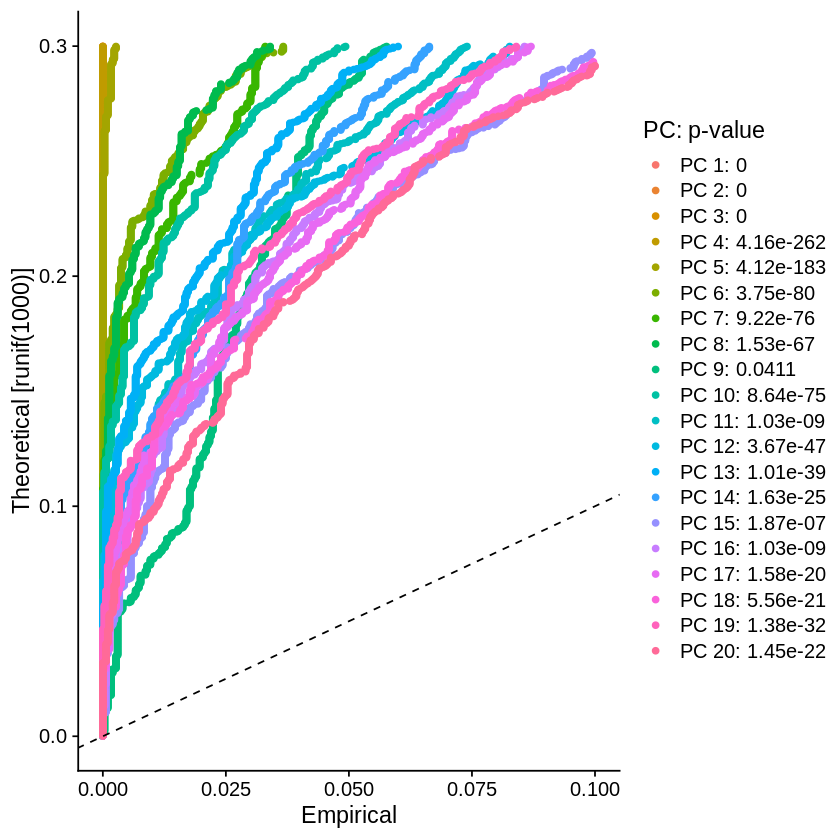

In [19]:
JackStrawPlot(normal, dims = 1:20)

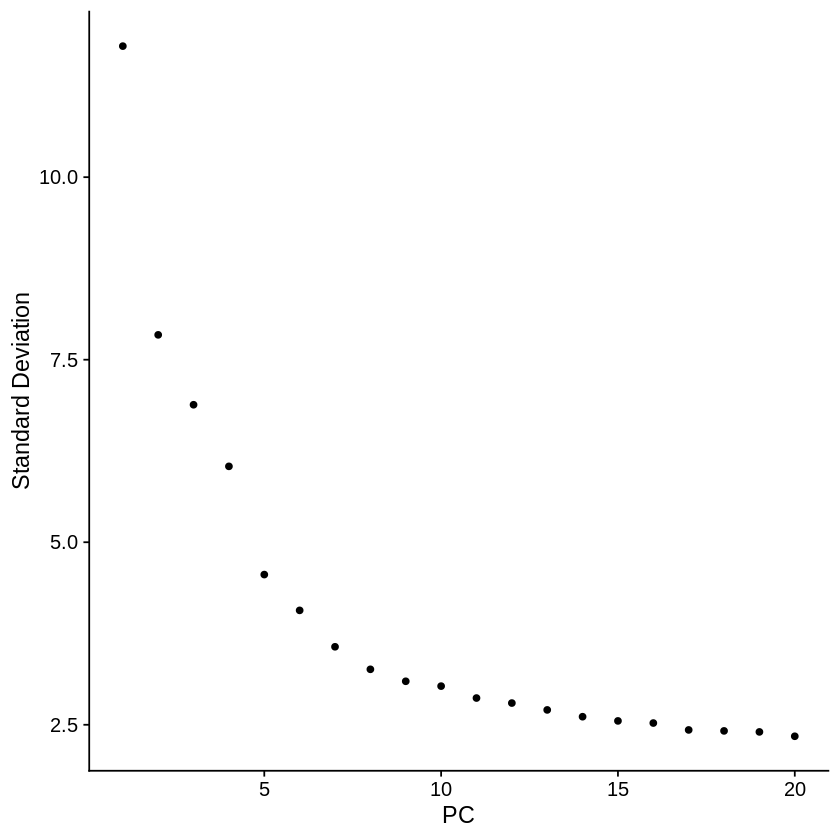

In [20]:
ElbowPlot(normal)

In [21]:
normal <- RunUMAP(normal, dims = 1:8)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:07:38 UMAP embedding parameters a = 0.9922 b = 1.112

13:07:38 Read 2334 rows and found 8 numeric columns

13:07:38 Using Annoy for neighbor search, n_neighbors = 30

13:07:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:07:38 Writing NN index file to temp file /tmp/RtmpmJUoCf/file8287e1bd7360d

13:07:38 Searching Annoy index using 1 thread, search_k = 3000

13:07:39 Annoy recall = 100%

13:07:39 Commencing smooth kNN distance calibration using 1 thread

13:07:39 Initializing fro

In [22]:
options(repr.plot.height=8,repr.plot.width=8)

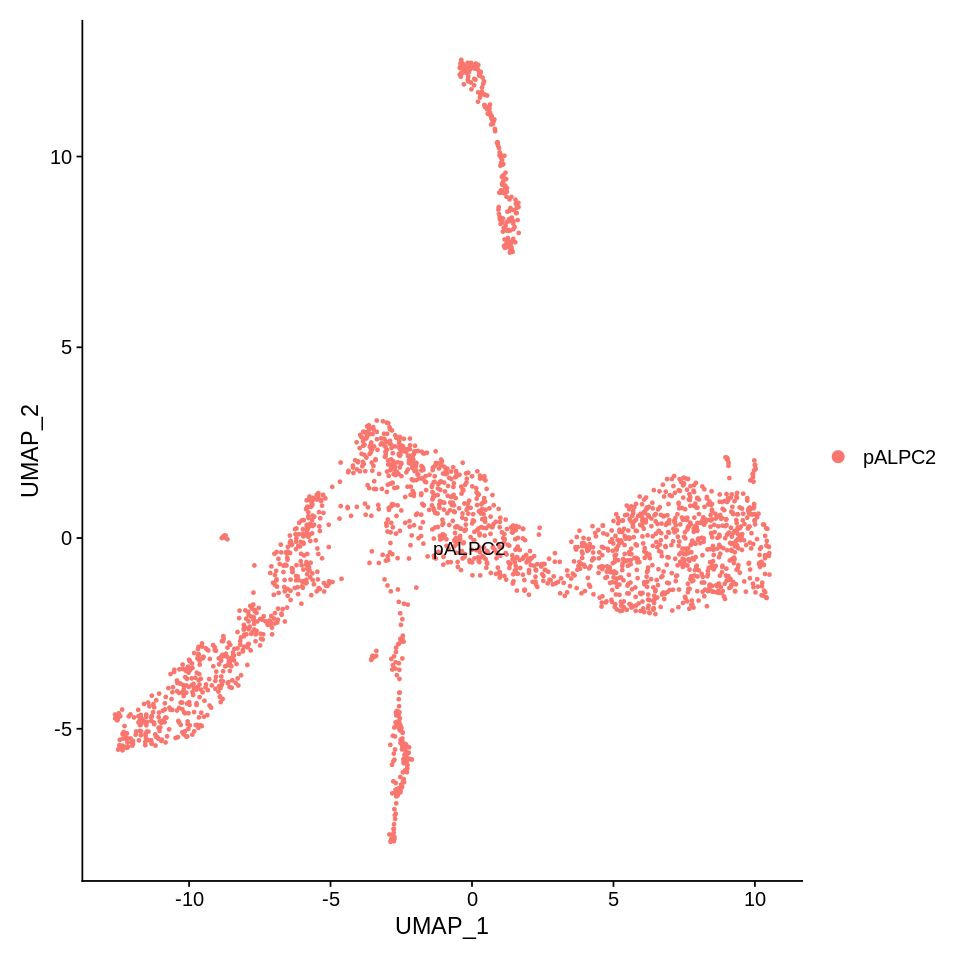

In [23]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


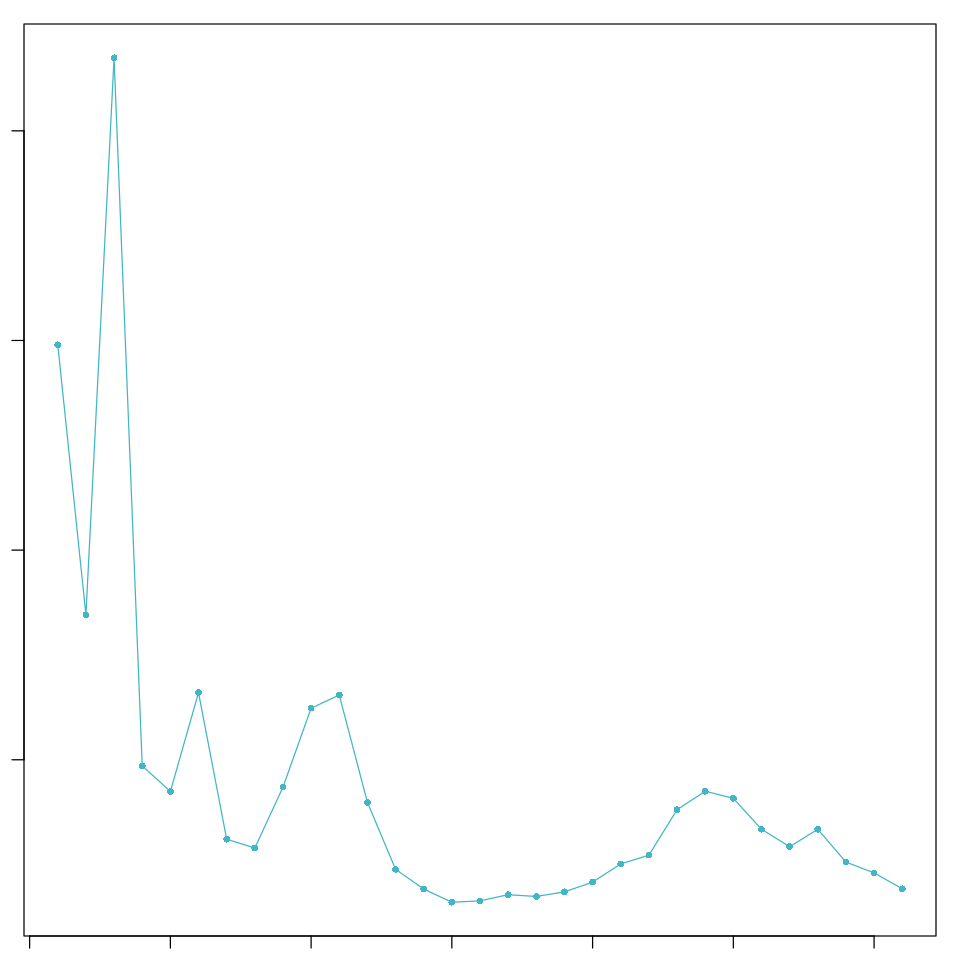

In [24]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:8, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [25]:
normal <- doubletFinder_v3(normal, PCs = 1:8, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 778 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [26]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

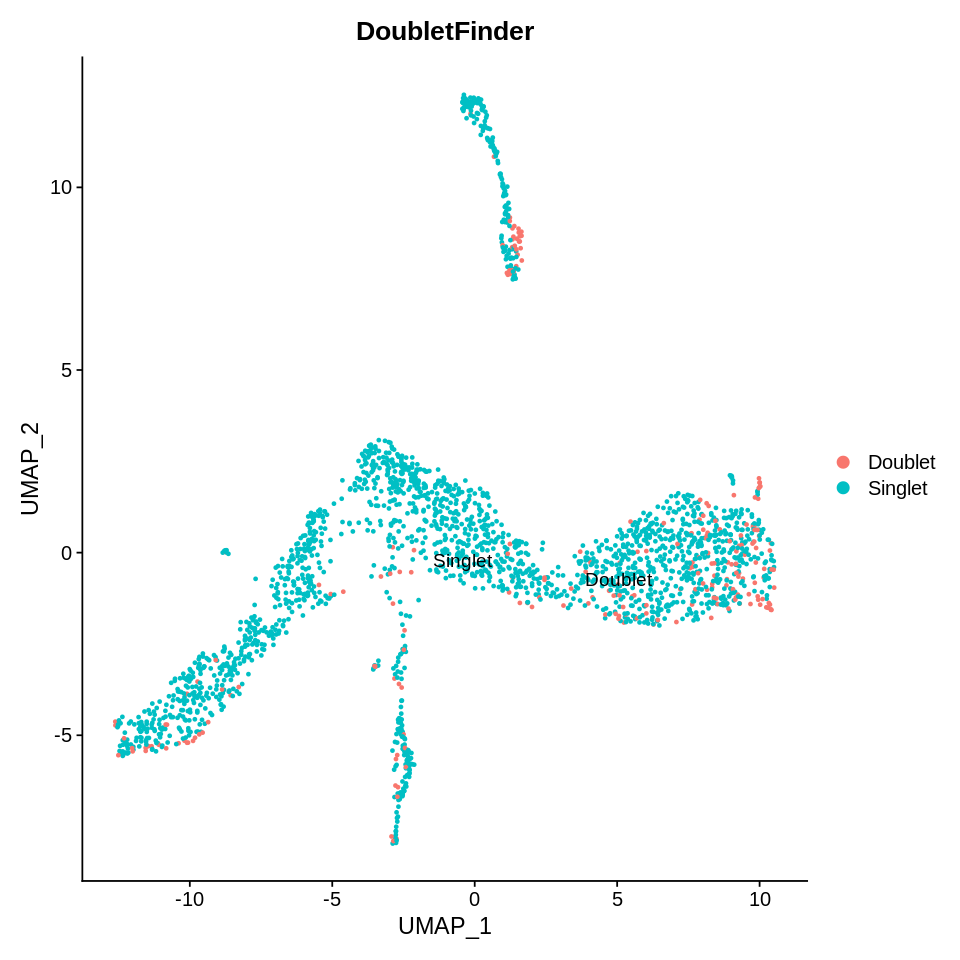

In [27]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [28]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [29]:
normal
normal2

An object of class Seurat 
16253 features across 2334 samples within 1 assay 
Active assay: RNA (16253 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
16253 features across 2101 samples within 1 assay 
Active assay: RNA (16253 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 79 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 79 rows containing missing values (geom_point).”


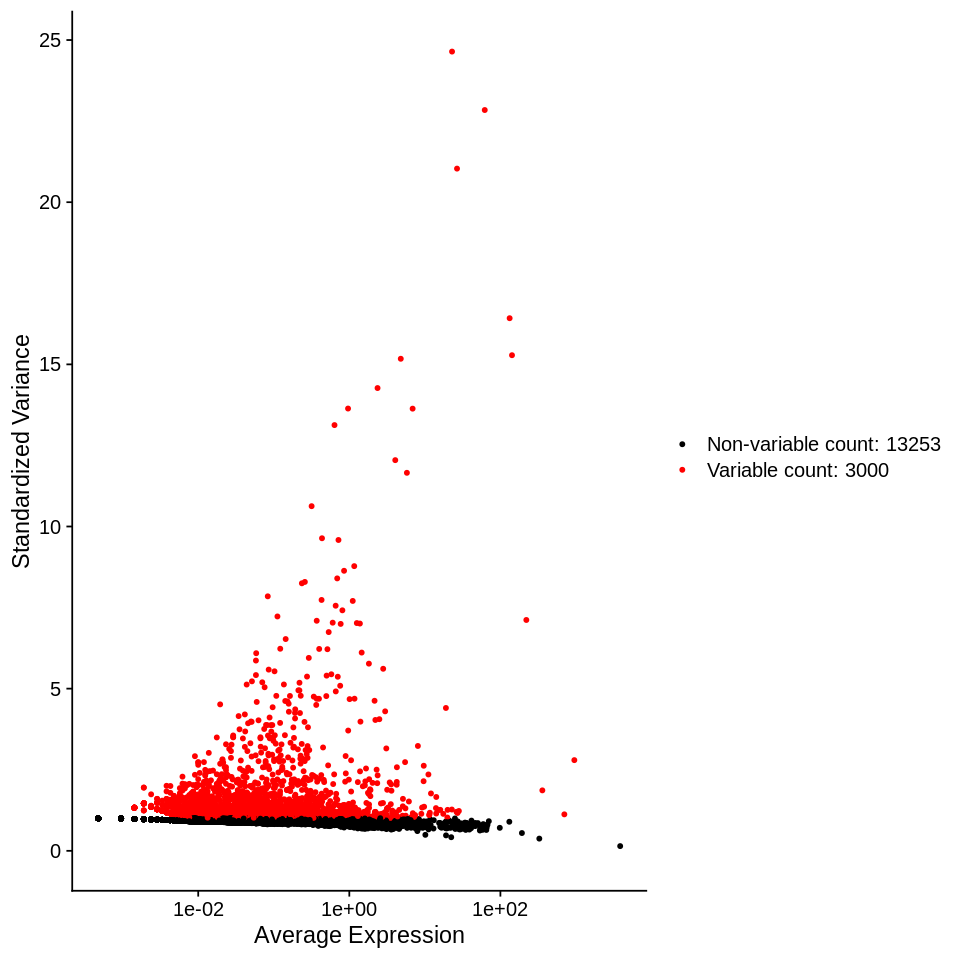

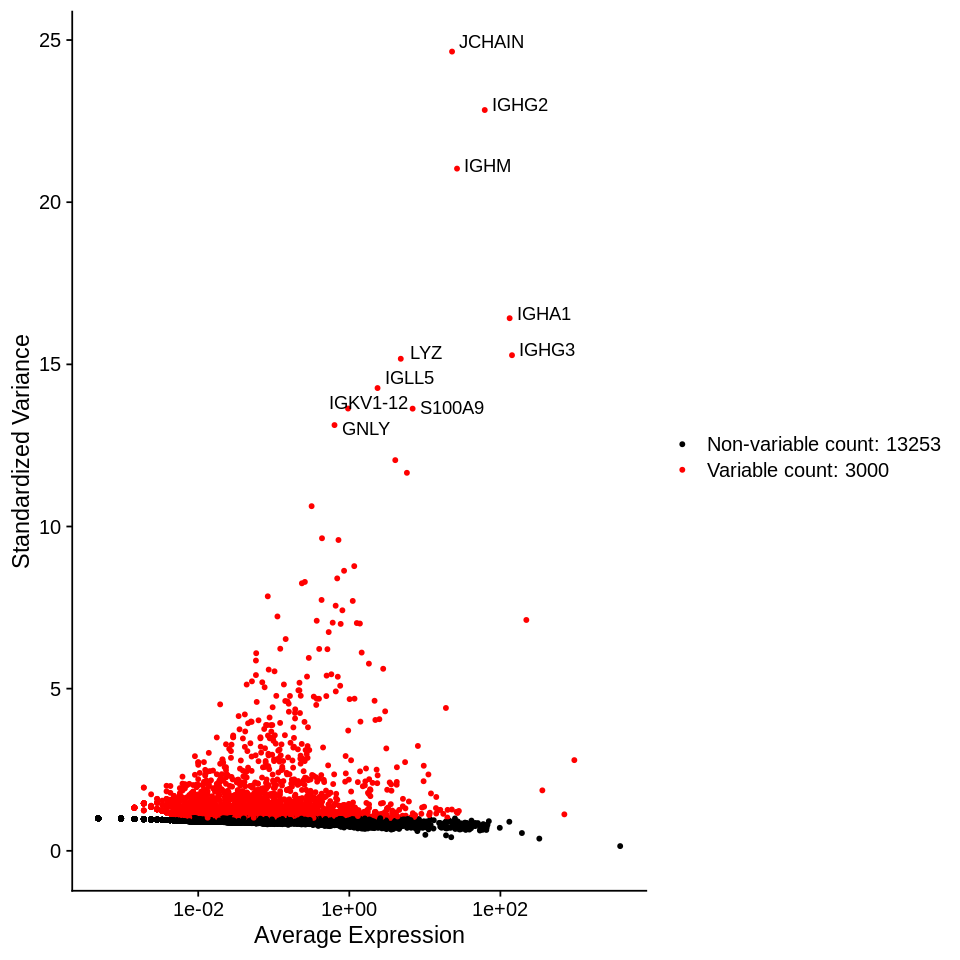

In [30]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [31]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [32]:
length(VariableFeatures(object = normal2))

[1] 3000

In [33]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  MZB1, FKBP11, SEC11C, ITM2C, HSP90B1, XBP1, FKBP2, IGLC3, DNAJB9, IGHG4 
	   DERL3, HERPUD1, GAS6, LMAN2, KRTCAP2, QPCT, HLA-DOB, TNFRSF17, IGHE, CUTA 
	   SDF2L1, UBE2J1, TXNDC11, JUN, KDELR1, TXNDC15, TUBB2B, SIL1, CD63, WBSCR22 
Negative:  TMSB4X, S100A4, COTL1, ARHGDIB, LAPTM5, TMSB10, CORO1A, PTPRC, LCP1, TYROBP 
	   S100A10, FCER1G, LST1, ITGB2, HLA-DRA, SH3BGRL3, ACTB, CSTA, FCN1, CFL1 
	   PFN1, CD52, MNDA, HLA-DPB1, S100A6, LSP1, SERPINA1, VCAN, CLEC12A, CFD 
PC_ 2 
Positive:  CSTA, SERPINA1, FCN1, VCAN, CD14, MNDA, CLEC12A, CFD, LYZ, FCER1G 
	   CTSS, FGL2, MPEG1, LGALS2, NCF2, SPI1, KCTD12, S100A12, TYMP, LST1 
	   CLEC7A, MS4A6A, CPVL, LGALS3, CD302, FOS, CST3, RNF130, CYBA, DUSP6 
Negative:  IL32, CD3E, TRAC, CD3D, TRBC2, LCK, CD7, CD2, CD3G, GZMM 
	   EVL, ACAP1, LTB, IL7R, LBH, LAT, CD247, GZMA, CCL5, TRBC1 
	   PRKCH, LINC00861, CLEC2D, CD8A, CST7, SH2D1A, NKG7, PRF1, HOPX, TBC1D10C 
PC_ 3 
Positive:  KIAA0101, STMN1, NUSAP1, BIRC5, HIST1H4C, CENPF, CD

In [34]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 42389 rows containing missing values (geom_point).”


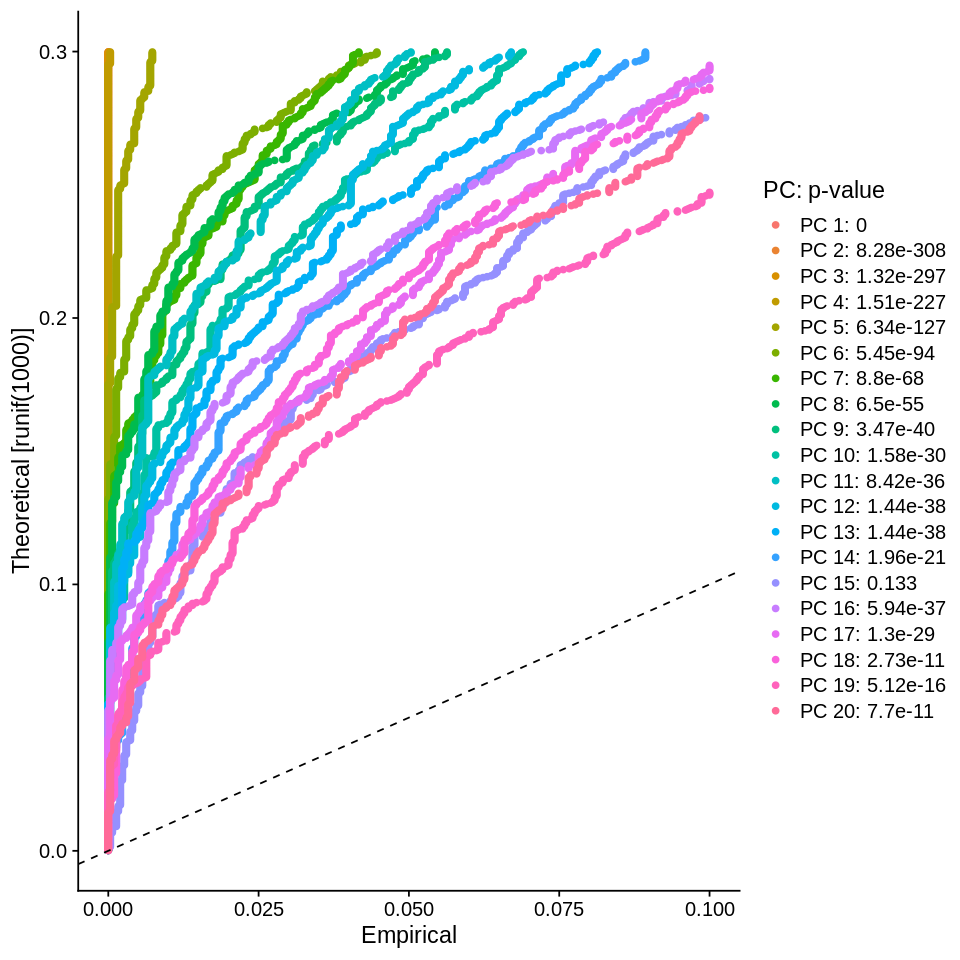

In [35]:
JackStrawPlot(normal2, dims = 1:20)

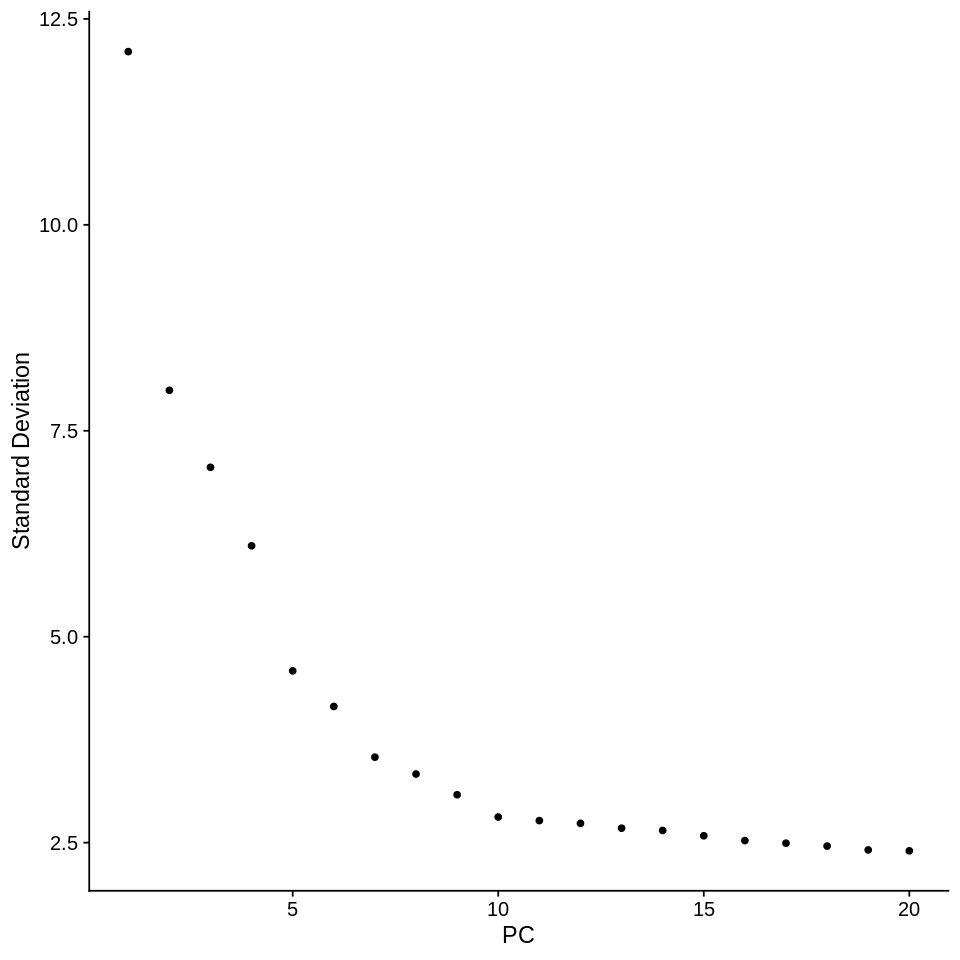

In [36]:
ElbowPlot(normal2)

In [37]:
normal2 <- FindNeighbors(normal2, dims = 1:15)
normal2 <- FindClusters(normal2, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2101
Number of edges: 80674

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8091
Number of communities: 9
Elapsed time: 0 seconds


In [38]:
normal2 <- RunUMAP(normal2, dims = 1:15)

13:09:07 UMAP embedding parameters a = 0.9922 b = 1.112

13:09:07 Read 2101 rows and found 15 numeric columns

13:09:07 Using Annoy for neighbor search, n_neighbors = 30

13:09:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:09:07 Writing NN index file to temp file /tmp/RtmpmJUoCf/file8287e7c35b805

13:09:07 Searching Annoy index using 1 thread, search_k = 3000

13:09:08 Annoy recall = 100%

13:09:08 Commencing smooth kNN distance calibration using 1 thread

13:09:09 Initializing from normalized Laplacian + noise

13:09:09 Commencing optimization for 500 epochs, with 88420 positive edges

13:09:11 Optimization finished



In [39]:
options(repr.plot.height=8,repr.plot.width=8)

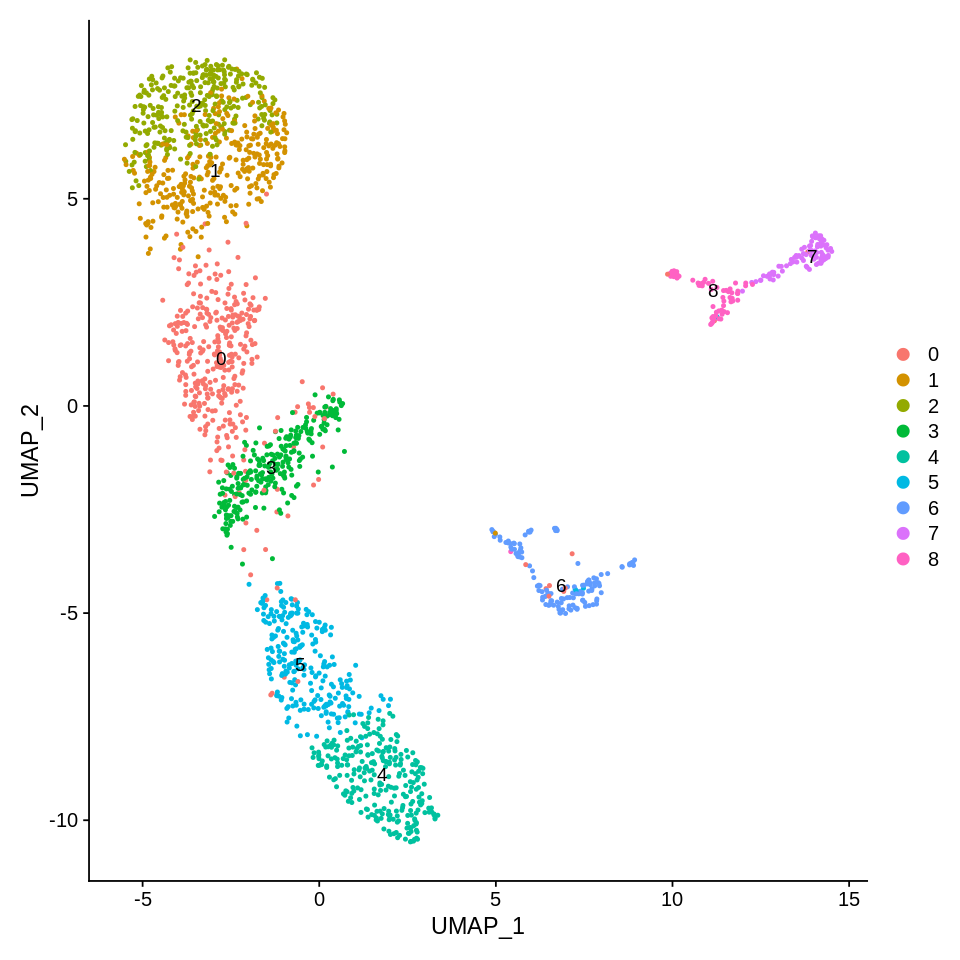

In [40]:
DimPlot(normal2, reduction = "umap",label=T)

In [60]:
options(repr.plot.height=9,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



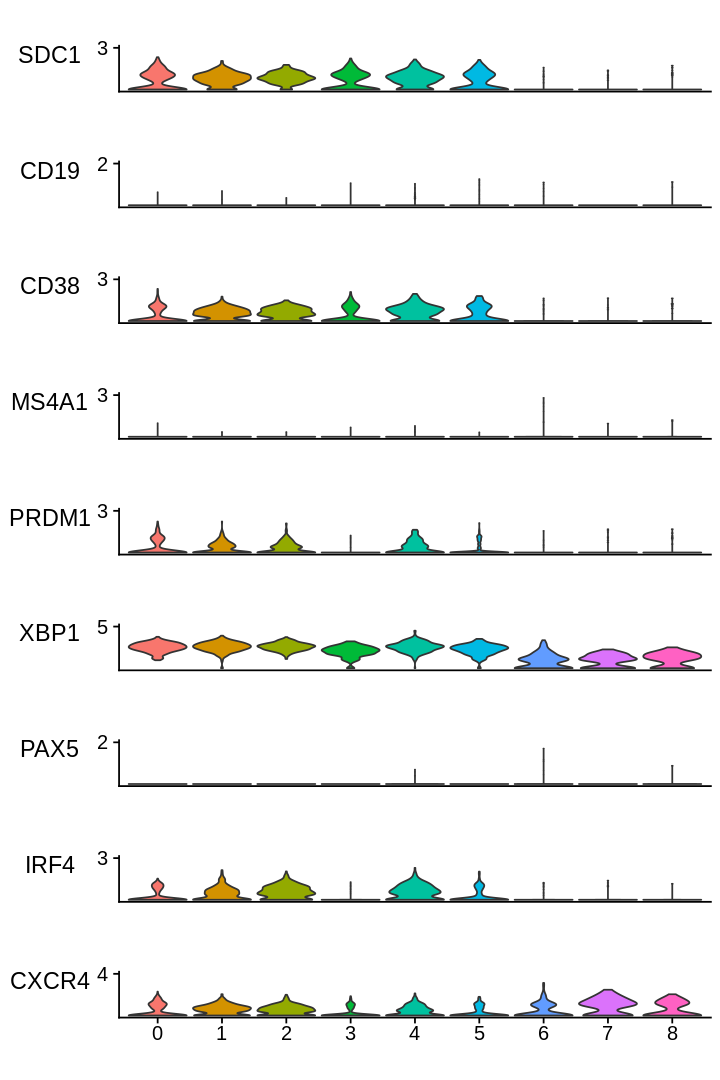

In [61]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



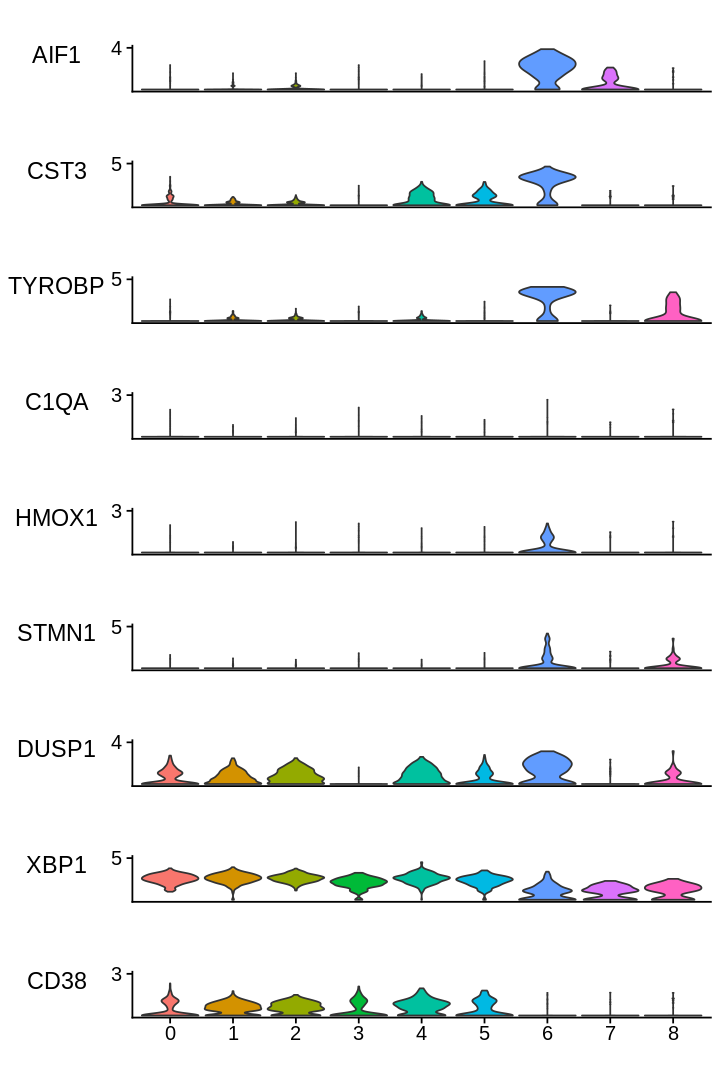

In [62]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [63]:
options(repr.plot.height=6,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



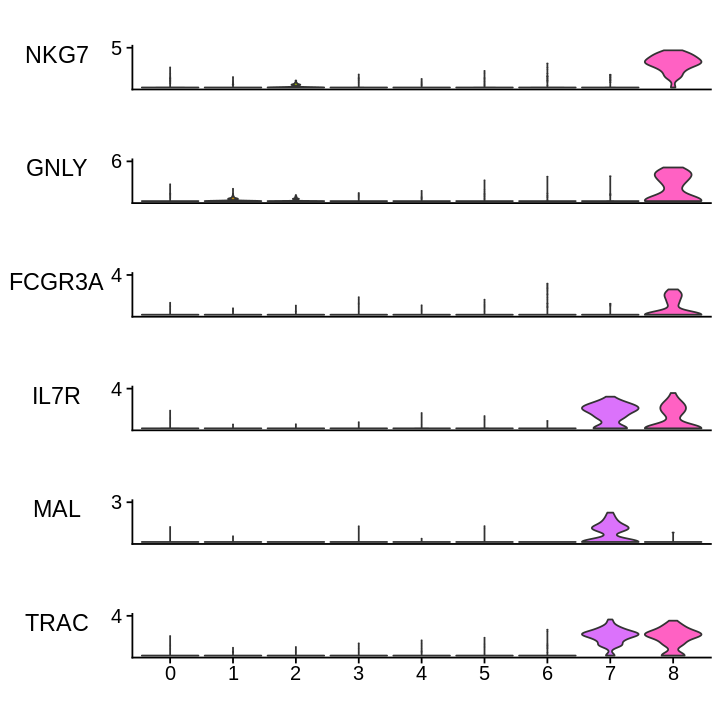

In [64]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



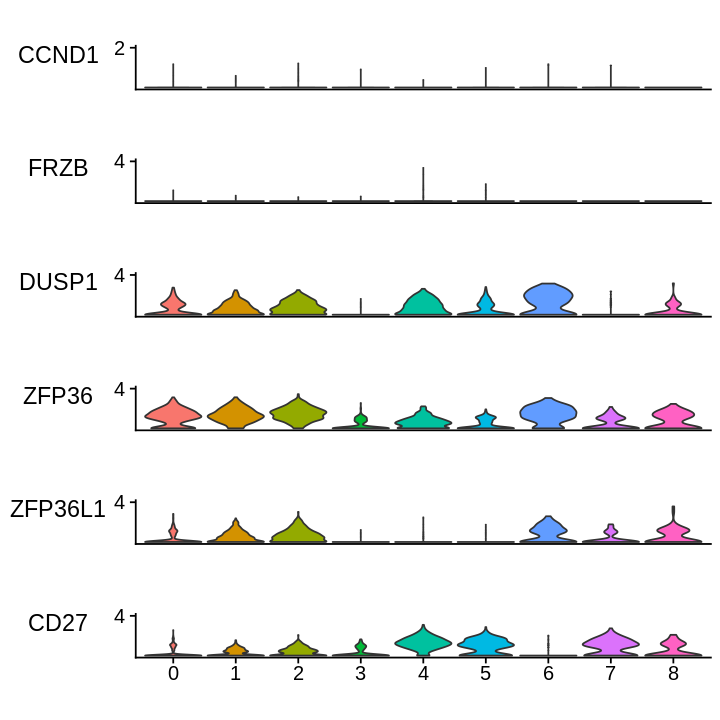

In [65]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [66]:
options(repr.plot.height=4,repr.plot.width=8)

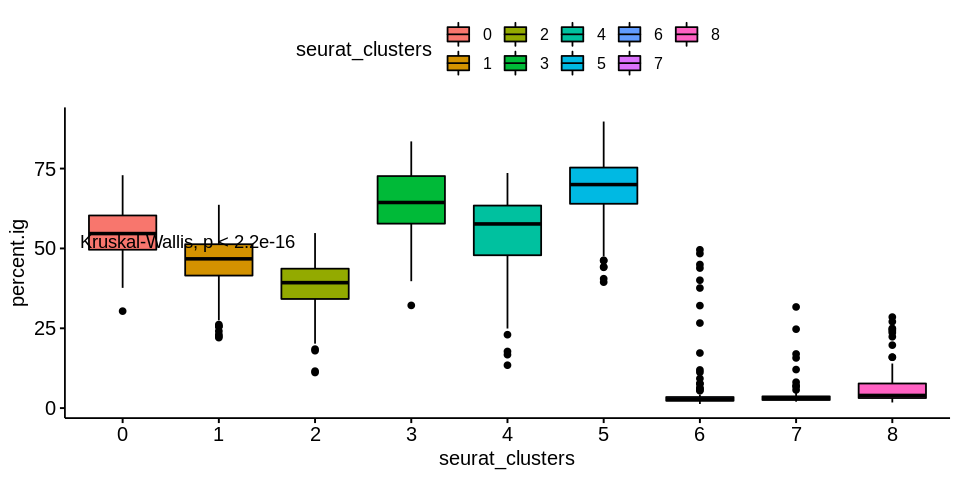

In [67]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

In [68]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
5.756857e-62,0.7366217,1.000,1.000,9.356619e-58,0,IGLC2
9.294399e-44,1.4545756,0.765,0.544,1.510619e-39,0,B4GALT1
1.181636e-26,0.6686138,1.000,0.974,1.920514e-22,0,MT-ND2
5.525097e-25,0.7284087,0.670,0.537,8.979940e-21,0,HNRNPH1
9.506600e-14,0.6923229,0.724,0.666,1.545108e-09,0,PIM2
8.102553e-54,0.6751521,0.792,0.293,1.316908e-49,1,CCDC144A
2.230785e-41,0.8416693,0.988,0.715,3.625694e-37,1,JUN
3.532847e-40,0.6451365,0.961,0.591,5.741936e-36,1,PTP4A3
8.126839e-38,0.6941251,0.985,0.666,1.320855e-33,1,IGHE


In [69]:
options(repr.plot.height=10,repr.plot.width=10)

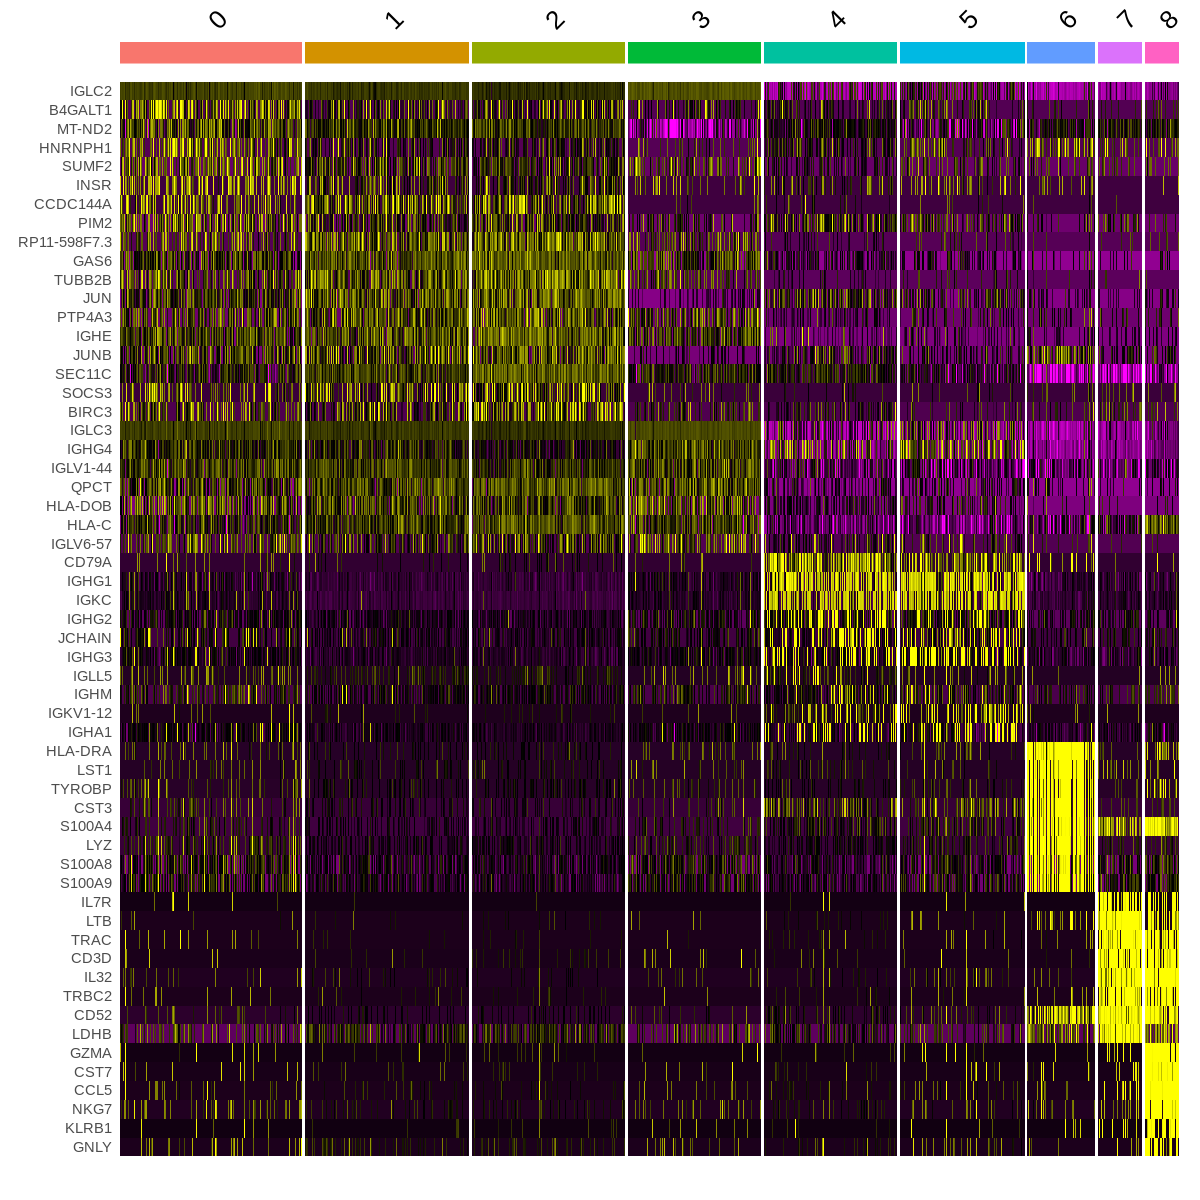

In [70]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

In [71]:
library("Seurat")
library("SingleR")

In [72]:
counts<-normal2@assays$RNA@counts
clusters<-normal2@meta.data$seurat_clusters
ann=normal2@meta.data$orig.ident

In [73]:
singler = CreateSinglerObject(counts, annot = ann, "normal",
  species = "Human", citation = "",
  ref.list = list(), variable.genes = "de",
  fine.tune = F, do.signatures = T, clusters = clusters, do.main.types = T,
  reduce.file.size = T, numCores = 1)

[1] "Dimensions of counts data: 16253x2101"
[1] "Annotating data with HPCA..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3297"
[1] "Number of cells: 2101"
[1] "Number of DE genes:3297"
[1] "Number of clusters: 9"
[1] "Annotating data with HPCA (Main types)..."
[1] "Number of DE genes:2579"
[1] "Number of cells: 2101"
[1] "Number of DE genes:2579"
[1] "Number of clusters: 9"
[1] "Annotating data with Blueprint_Encode..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3155"
[1] "Number of cells: 2101"
[1] "Number of DE genes:3155"
[1] "Number of clusters: 9"
[1] "Annotating data with Blueprint_Encode (Main types)..."
[1] "Number of DE genes:2589"
[1] "Number of cells: 2101"
[1] "Number of DE genes:2589"
[1] "Number of clusters: 9"


In [74]:
singler$seurat = normal
singler$meta.data$xy = normal2@reductions$umap@cell.embeddings
clusterAnn=singler$singler[[2]]$SingleR.clusters.main$labels
clusterAnn

0,B-cells
1,B-cells
2,B-cells
3,B-cells
4,B-cells
5,B-cells
6,Monocytes
7,CD4+ T-cells
8,CD8+ T-cells


In [75]:
clusterAnn<-as.data.frame(clusterAnn)
clusterAnn

,V1
,<chr>
0,B-cells
1,B-cells
2,B-cells
3,B-cells
4,B-cells
5,B-cells
6,Monocytes
7,CD4+ T-cells
8,CD8+ T-cells


In [76]:
type<-as.data.frame(singler$other)
type

,singler$other
,<chr>
AAACGGGAGGCCATAG-1,CD14+ Monocytes
AAAGATGCAAGCGAGT-1,CD14+ Monocytes
AAAGATGCAGAAGCAC-1,CD4 T cells
AAAGATGGTTCTCATT-1,CD14+ Monocytes
AAAGCAACATTGTGCA-1,CD14+ Monocytes
AAAGCAATCGTATCAG-1,B cells
AAAGTAGGTACTTAGC-1,B cells
AAAGTAGTCCACTCCA-1,CD14+ Monocytes
AAATGCCAGAGCTGGT-1,B cells


In [77]:
count<-table(type)
count

type
          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
              258              1337               318                66 
  Dendritic cells FCGR3A+ Monocytes    Megakaryocytes          NK cells 
               30                25                46                21 

In [78]:
names<-as.vector(rownames(normal2@meta.data))
type2<-type[names,]

In [79]:
plasma<-subset(normal2,ident=c(0,1,2,3,4,5))

In [80]:
options(repr.plot.height=8,repr.plot.width=8)

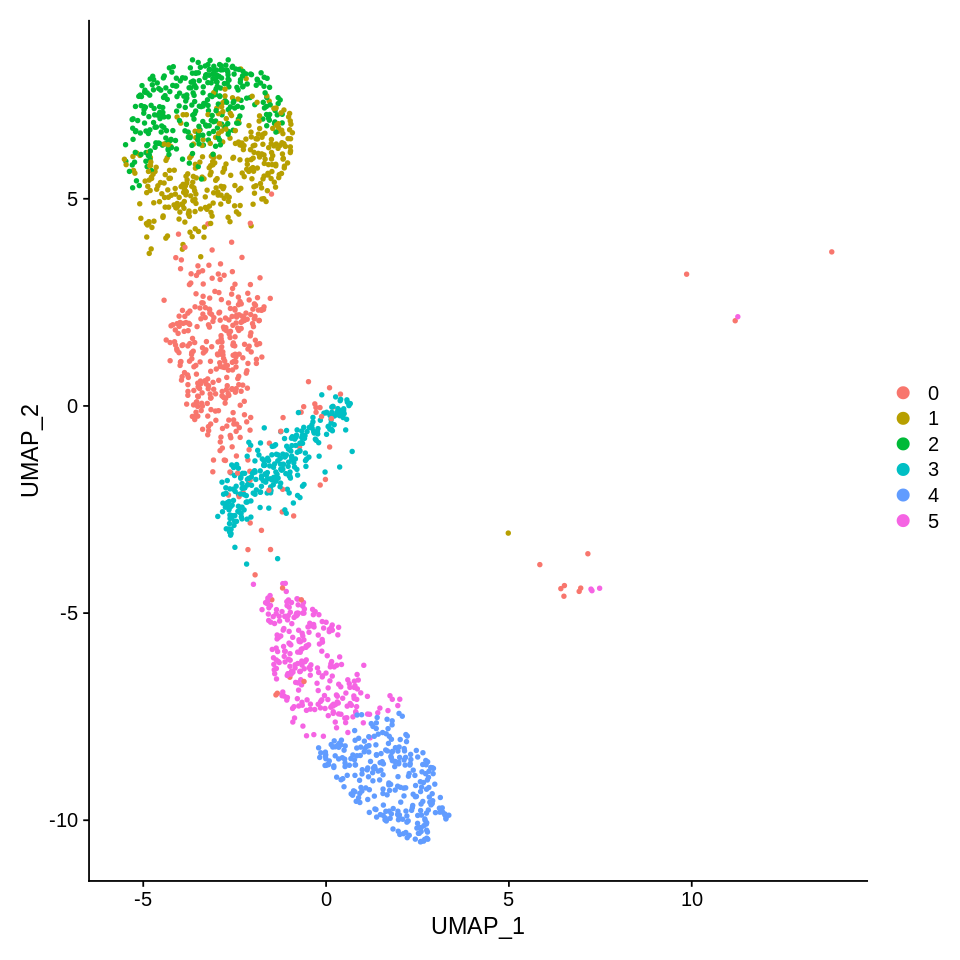

In [81]:
DimPlot(plasma, reduction = "umap")

In [82]:
plasma.markers <- FindAllMarkers(plasma, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
plasma.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
9.748727e-35,1.3327653,0.765,0.609,1.584461e-30,0,B4GALT1
1.022900e-31,0.6456854,1.000,0.967,1.662519e-27,0,MT-CO2
9.245999e-28,0.8368084,0.670,0.549,1.502752e-23,0,HNRNPH1
8.595018e-26,0.6631016,1.000,0.969,1.396948e-21,0,MT-ND2
5.135120e-24,0.6003123,0.986,0.939,8.346111e-20,0,MT-CYB
5.665711e-16,0.6124960,0.516,0.396,9.208480e-12,0,INSR
1.746591e-13,0.7676984,0.832,0.884,2.838734e-09,0,S100A9
1.345490e-12,0.7013540,0.808,0.886,2.186826e-08,0,S100A8
2.618372e-08,0.5825855,0.724,0.746,4.255640e-04,0,PIM2


In [83]:
options(repr.plot.height=8,repr.plot.width=8)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



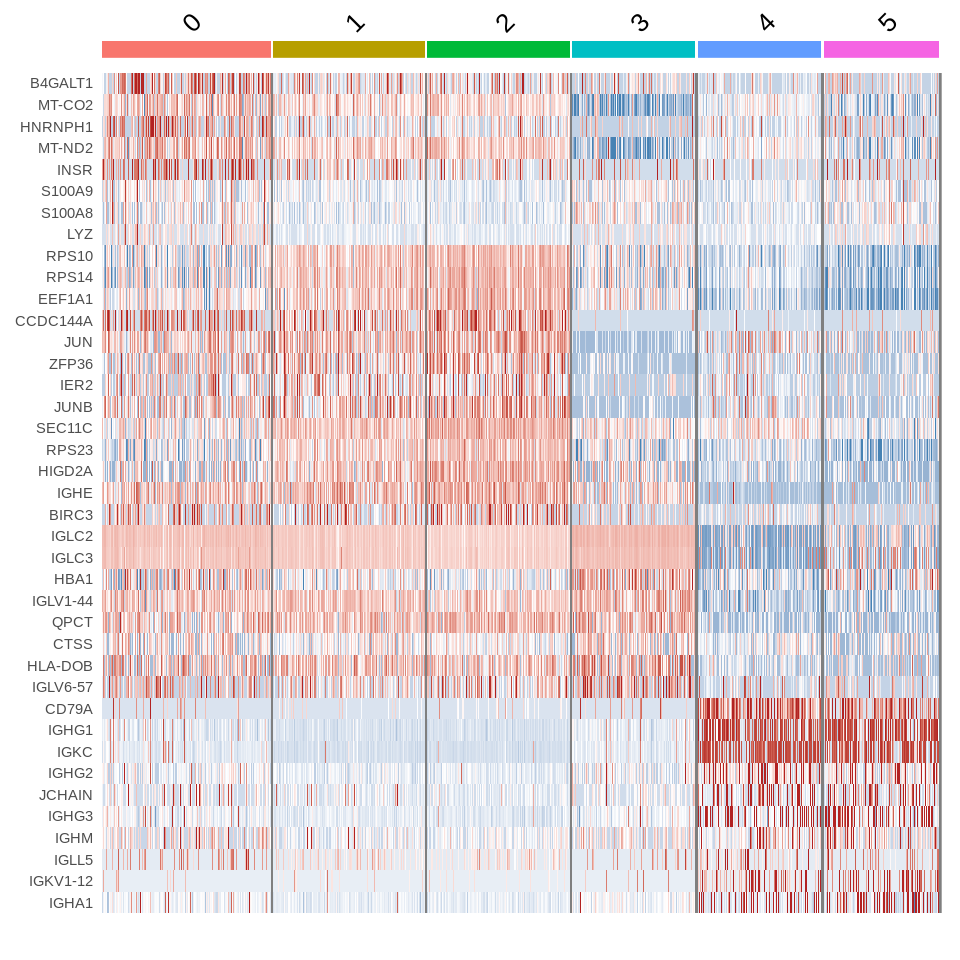

In [84]:
top10 <- plasma.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(plasma, features = top10$gene) + NoLegend()+ scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))

In [85]:
save(plasma,file="0709-pALPC2-plasma.Rda")

In [86]:
plasma

An object of class Seurat 
16253 features across 1806 samples within 1 assay 
Active assay: RNA (16253 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

In [87]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



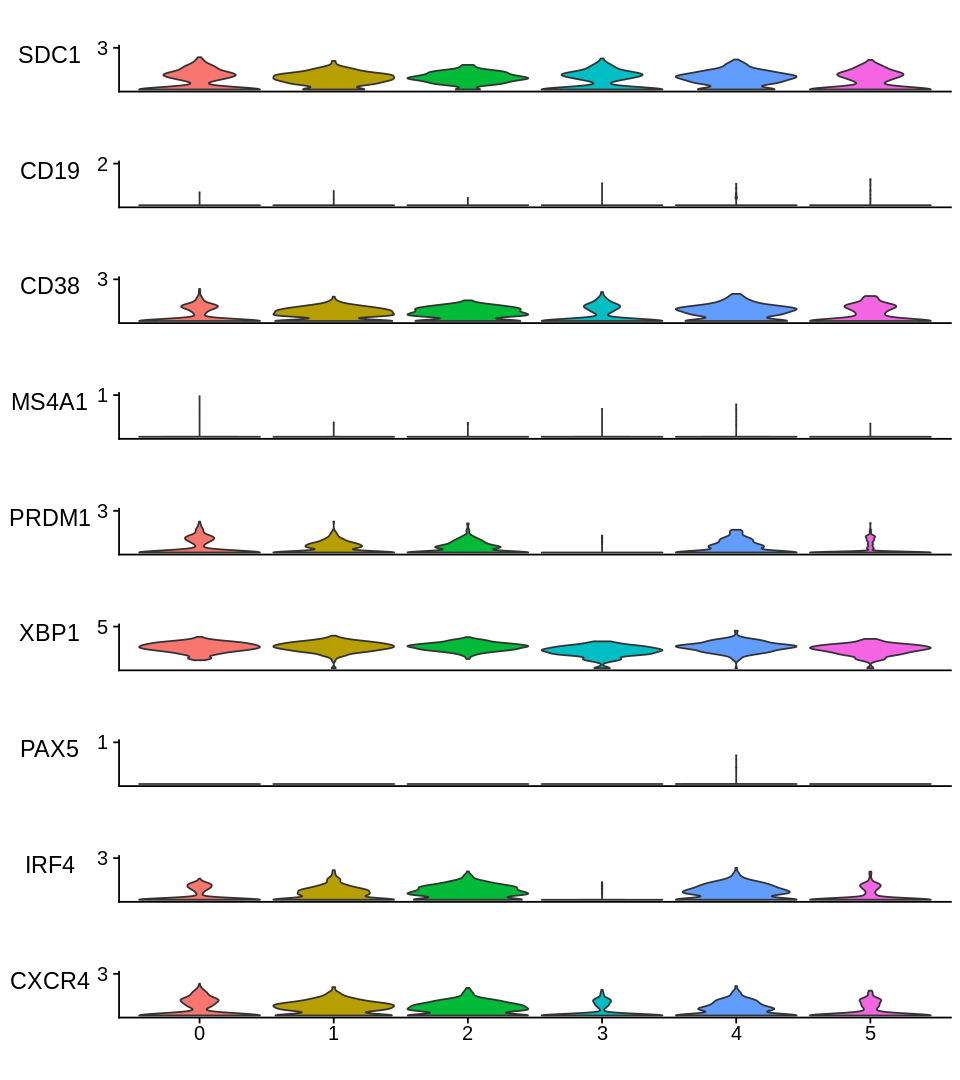

In [88]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



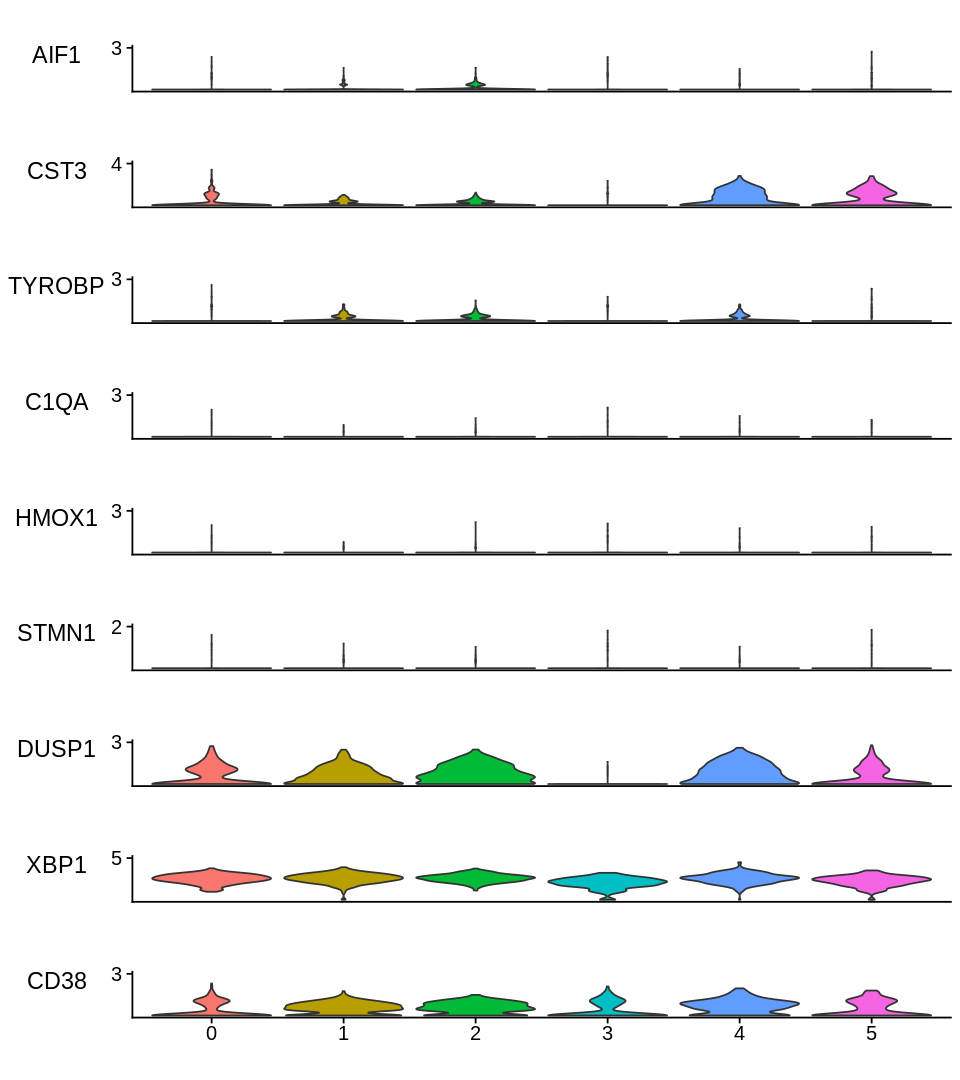

In [89]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =plasma, features = features)

In [90]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



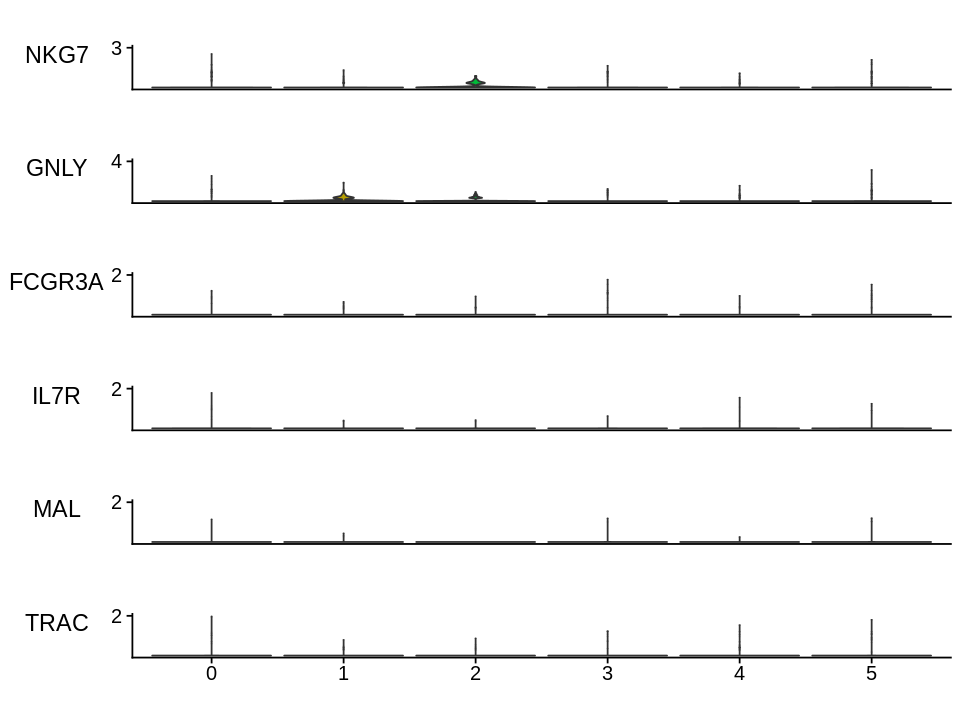

In [91]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



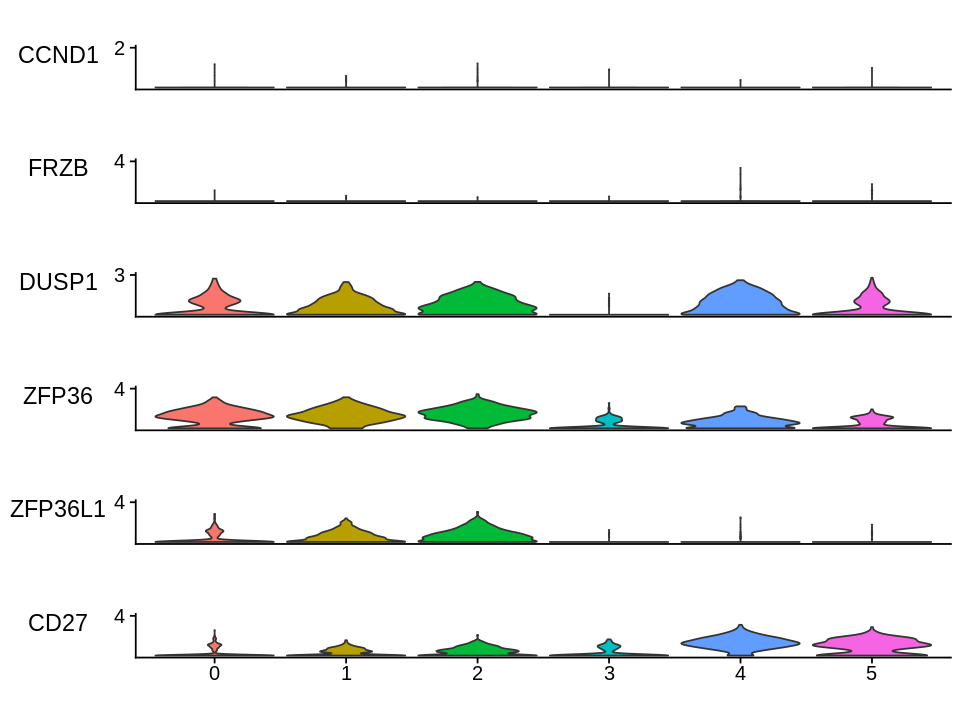

In [92]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =plasma, features = features)